# Ordinary and Simple Kriging

## Table of Contents:

1. Read point data,
2. Set semivariogram model,
3. Set Ordinary Kriging and Simple Kriging models,
4. Predict values at unknown locations.

## Level: Basic

## Changelog

| Date       | Change description                                                                                                                                                | Author         |
|------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| 2023-04-15 | Tutorial debugged and updated to the 0.4.1 version of the package                                                     | @SimonMolinsky |
| 2022-11-05 | Tutorial updated for the 0.3.5 version of the package                                                                                                             | @SimonMolinsky |
| 2022-08-20 | The tutorial is updated to the version 0.3.0 of the package                                                                                                       | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class & error variance estimated in a correct way | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                                                                           | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed                                                                                                    | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class                                                                                                                         | @SimonMolinsky |
| 2021-04-03 | Simple Kriging `global_mean` parameter update.                                                                                                                    | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated point data source.                                                                               | @SimonMolinsky |

## Introduction

This tutorial will teach us how to perform spatial interpolation with Ordinary and Simple Kriging. We will compare a different number of ranges, and test outcomes of processing with the root mean squared error.

Ordinary and Simple Kriging is the simplest form of Kriging, but they're still powerful techniques.

We use DEM data which is stored in a file `samples/point_data/txt/pl_dem_epsg2180.txt`.

## Import packages

In [1]:
from typing import List

import numpy as np

from pyinterpolate import read_txt, build_experimental_variogram, build_theoretical_variogram, kriging

## 1) Read point data

In [2]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')
dem[: 3]

array([[2.37685325e+05, 5.45416708e+05, 5.12545509e+01],
       [2.37674140e+05, 5.45209671e+05, 4.89582825e+01],
       [2.37449255e+05, 5.41045935e+05, 1.68178635e+01]])

In the beginning, we remove 70 % of our points from the dataset, and we will leave them as a test set to estimate how good our models are.

In [3]:
def create_train_test(dataset: np.ndarray, training_set_ratio=0.3):
    """
    Function divides base dataset into a training and a test set.

    Parameters
    ----------
    dataset : np.ndarray

    training_set_ratio : float, default = 0.3
    
    Returns
    -------
    training_set, test_set : List[np.ndarray]
    """

    np.random.seed(101)  # To ensure that we will get the same results every time

    indexes_of_training_set = np.random.choice(range(len(dataset) - 1), int(training_set_ratio * len(dataset)), replace=False)
    training_set = dataset[indexes_of_training_set]
    validation_set = np.delete(dataset, indexes_of_training_set, 0)
    return training_set, validation_set


train_set, test_set = create_train_test(dem)

We have removed a subset of points from a dataset to be sure that Kriging is working. In this scenario, 70% of available points are removed, but in real-world cases, you will probably have even fewer points to perform estimations, down to the 1% of known values.

Function `create_train_test()` divides our dataset into two subsets:

- **training set** used for semivariogram model derivation,
- **test set** used for the model error calculation.

Points for each set are chosen randomly to avoid bias related to the geographical location. Let's imagine we have a sorted list of Digital Elevation Model points. The western part of our measurements covers a mountain, and the eastern part is plain. When we use the part of the west for modeling and the east part for tests, we are going directly into a catastrophe! That's why it's better to perform multiple random sampling and test multiple realizations from our data. We will prepare only one realization with a fixed random seed, but you should be aware that in the real-world analysis, we must test more realizations (e.g., set multiple random seeds).

## 2) Set Semivariogram model

In this step, we are going to create experimental and theoretical semivariograms.

In [4]:
# Create experimental semivariogram

# Prepare experimental semivariogram

step_radius = 500  # meters
max_range = 10000  # meters

exp_semivar = build_experimental_variogram(input_array=train_set, step_size=step_radius, max_range=max_range)

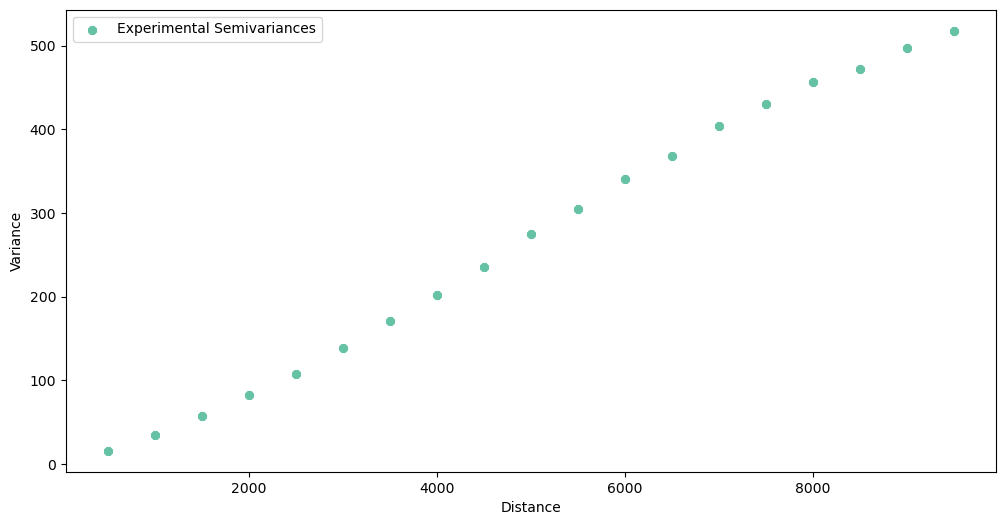

In [5]:
# Plot experimental semivariogram

exp_semivar.plot()

In [6]:
# Fit data into a theoretical model

semivar = build_theoretical_variogram(experimental_variogram=exp_semivar, model_type='linear', sill=exp_semivar.variance, rang=10000)

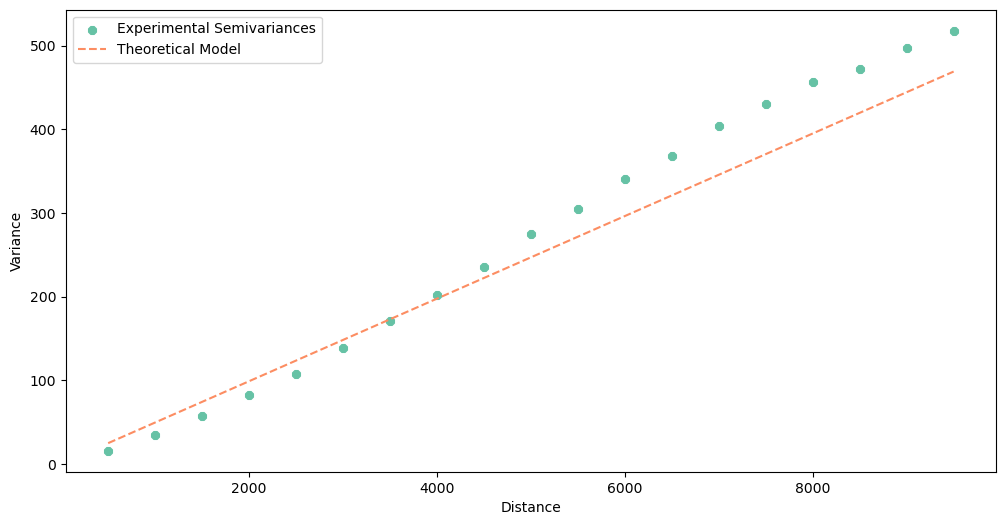

In [7]:
semivar.plot()

In [8]:
print(semivar)

* Selected model: Linear model
* Nugget: 0.0
* Sill: 493.778772754868
* Range: 10000
* Spatial Dependency Strength is Unknown
* Mean Bias: 21.92700357030904
* Mean RMSE: 37.17324824914244
* Error-lag weighting method: None


+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |     bias (y-y')     |
+--------+--------------------+--------------------+---------------------+
| 500.0  |  24.6889386377434  | 15.614084077885668 |  -9.074854559857734 |
| 1000.0 |  49.3778772754868  | 34.151521896711735 | -15.226355378775068 |
| 1500.0 |  74.0668159132302  | 56.61060460335831  |  -17.45621130987189 |
| 2000.0 |  98.7557545509736  | 81.75250857008155  |  -17.00324598089206 |
| 2500.0 |  123.444693188717  | 107.39147411240353 | -16.053219076313468 |
| 3000.0 | 148.1336318264604  | 138.01527174633642 | -10.118360080123978 |
| 3500.0 | 172.82257046420378 | 170.17760461535644 | -2.6449658488473347 |
| 4000.0 | 197.5115091019

## 3) Set Ordinary Kriging and Simple Kriging models

This is the essential step of our tutorial. We've set our semivariogram model, and now we can perform the prediction of unknown values. We will "predict" a known and arbitrary point in the first run. It is a test of Kriging which should work as **an unbiased linear estimator**. Thus it should return the **exact** value if we pass into it a point used for training. In the second step, we will try to guess values at unknown locations and calculate the **R**oot **M**ean **S**quared **E**rror (RMSE) of interpolated values.

We can use the same `kriging()` function for both kriging types. It takes those arguments:

- `observations`: array with known points,
- `theoretical_model`: fitted `TheoreticalVariogram` model,
- `points`: points to interpolate values,
- `how`: `ok` - ordinary kriging, `sk` - simple kriging,
- `neighbors_range`: `None` or `float`, the maximum distance where we search for point neighbors. If `None` is given, then the range is selected from the `theoretical_model` `rang` attribute.
- `no_neighbors`: `int`, number of neighbors to estimate unknown value.
- `use_all_neighbors_in_range`: `bool`, default is `False`. `True`: if the number of neighbors within the `neighbors_range` is greater than the `number_of_neighbors` then take all of them for modeling.
- `sk_mean`: `None` or `float`, the mean value of a process over a study area. It should be known before processing, and that's why Simple Kriging has a limited number of applications. You must have multiple samples and a well-known area to use this parameter.
- `allow_approx_solutions`: Allows the approximation of kriging weights based on the OLS algorithm. Not recommended to set it to `True` if you don't know what you are doing! By default, it is set to `False`,
- `number_of_workers`: if we pass more than 10k points to interpolate, it is recommended to set this parameter to the number of your CPU workers (or -1) - it will speed up calculations.

We use only the first four parameters and `sk_mean` when we perform Simple Kriging. Let's start! The first step is an interpolation of the value known by our model.

In [9]:
# Select one known value

known_value = train_set[10]
known_value

array([2.49304390e+05, 5.40766289e+05, 2.03649998e+01])

In [10]:
# Predict with Ordinary Kriging

ok_interpolation = kriging(train_set, semivar, [known_value[:-1]])
ok_interpolation

100%|██████████| 1/1 [00:00<00:00, 520.06it/s]


array([[2.03649998e+01, 0.00000000e+00, 2.49304390e+05, 5.40766289e+05]])

The first value is our prediction: it is precisely the same as the input in the training set! So far, the algorithm has worked well. The second value is prediction variance error, and it is equal to zero - we are sure it is the exact value.

Simple Kriging is slightly different than Ordinary Kriging, and we must set the process mean to retrieve valid results. It is rarely the case. That's why Ordinary Kriging is the first choice for many applications. We know the global mean because we have the whole dataset, but in the real-world scenario, we cannot divide the set into training and test sets and then get the mean from the entire dataset - it is an information leak from the test set into a model!

In [11]:
sk_interpolation = kriging(train_set, semivar, [known_value[:-1]], how='sk', sk_mean=float(np.mean(dem)))
sk_interpolation

100%|██████████| 1/1 [00:00<00:00, 717.22it/s]


array([[2.03649998e+01, 0.00000000e+00, 2.49304390e+05, 5.40766289e+05]])

The Simple Kriging algorithm returns the same output as the Ordinary Kriging: `[prediction, error variance, pt x, pt y]`. And as with Ordinary Kriging, Simple Kriging has returned the same value as the actual value fed to the algorithm.

## 4) Predict values at unknown locations

Using kriging for interpolation of known points values is pointless, and it is an excellent tool for a testing algorithm but nothing more. Here we will interpolate with Kriging, and we will interpolate values at unknown locations. Additionally, we will control the `no_neighbors` parameter to check how it influences predictions.

In the first step, we will create a simple function to test our kriging results and calculate RMSE.

In [12]:
def test_kriging(train_data, variogram_model, ktype, test_values, number_of_neighbors, sk_mean_value=None):
    predictions = kriging(observations=train_data,
                          theoretical_model=variogram_model,
                          points=test_values[:, :-1],
                          how=ktype,
                          no_neighbors=number_of_neighbors,
                          number_of_workers=1,
                          sk_mean=sk_mean_value)
    mse = np.mean((predictions[:, 0] - test_values[:, -1])**2)
    rmse = np.sqrt(mse)
    return rmse

In [13]:
# Number of neighbors

no_of_n = [4, 8, 16, 32, 64, 128, 256]
print('Ordinary Kriging: tests')
print('')

for nn in no_of_n:
    print('Number of neighbors:', nn)
    rmse_pred = test_kriging(train_data=train_set, variogram_model=semivar, ktype='ok', test_values=test_set, number_of_neighbors=nn)
    print('RMSE:', rmse_pred)
    print('')

Ordinary Kriging: tests

Number of neighbors: 4


100%|██████████| 4826/4826 [00:01<00:00, 3048.02it/s]


RMSE: 3.404341396262182

Number of neighbors: 8


100%|██████████| 4826/4826 [00:01<00:00, 3065.26it/s]


RMSE: 3.2909488461696372

Number of neighbors: 16


100%|██████████| 4826/4826 [00:01<00:00, 3014.26it/s]


RMSE: 3.2674275543792795

Number of neighbors: 32


100%|██████████| 4826/4826 [00:01<00:00, 2891.03it/s]


RMSE: 3.2608735889738663

Number of neighbors: 64


100%|██████████| 4826/4826 [00:02<00:00, 1793.23it/s]


RMSE: 3.2565732386644757

Number of neighbors: 128


100%|██████████| 4826/4826 [00:03<00:00, 1265.04it/s]


RMSE: 3.254786835977034

Number of neighbors: 256


100%|██████████| 4826/4826 [00:07<00:00, 630.09it/s]


RMSE: 3.2550170696805028



In [14]:
print('Simple Kriging: tests')
print('')

sk_mean = np.mean(dem[:, -1])

for nn in no_of_n:
    print('Number of neighbors:', nn)
    rmse_pred = test_kriging(train_data=train_set, variogram_model=semivar, ktype='sk', test_values=test_set, number_of_neighbors=nn, sk_mean_value=sk_mean)
    print('RMSE:', rmse_pred)
    print('')

Simple Kriging: tests

Number of neighbors: 4


100%|██████████| 4826/4826 [00:01<00:00, 3585.48it/s]


RMSE: 8.697161939348147

Number of neighbors: 8


100%|██████████| 4826/4826 [00:01<00:00, 3656.47it/s]


RMSE: 3.650066190084651

Number of neighbors: 16


100%|██████████| 4826/4826 [00:01<00:00, 3564.85it/s]


RMSE: 3.348632949010878

Number of neighbors: 32


100%|██████████| 4826/4826 [00:01<00:00, 3362.75it/s]


RMSE: 3.278583712643331

Number of neighbors: 64


100%|██████████| 4826/4826 [00:02<00:00, 2142.62it/s]


RMSE: 3.261651162610457

Number of neighbors: 128


100%|██████████| 4826/4826 [00:03<00:00, 1442.88it/s]


RMSE: 3.255919635781099

Number of neighbors: 256


100%|██████████| 4826/4826 [00:07<00:00, 666.08it/s]

RMSE: 3.25433234347302



Usually, Simple Kriging will give us worse results than Ordinary Kriging because we do not know process mean. Only if we know the process mean we can use Simple Kriging with a large number of neighbors. We see that the results of Simple Kriging are better when we pass more values into it. This shouldn't be a shock, Simple Kriging *knows* the global mean and utilizes this information when building a Kriging system.

On the other hand, Ordinary Kriging is a swiss knife in our geostatistical toolbox. It works well even if we don't know process mean, and it should be our first-choice technique.

Let's look into processing times with a growing number of neighbors. We can theoretically take more and more neighbors, but is it worth it?

- **Small dataset**: with small datasets (up to 1000 points), we may consider using a large number of neighbors. It shouldn't be a problem for processing time.
- **Large dataset**: more than 5000 points? Then we must take into account two scenarios:
1. A single report or only a one-time analysis - then use as many neighbors as it is possible (within range);
2. Near-real time and systematic analyses - use fewer neighbors, between 8 - 128. I usually use 32 neighbors for datasets with more than 1000 point pairs.

---